In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
ticker = '^GSPC'
sp500 = yf.Ticker(ticker)
data = sp500.history(period='10y', interval='1d')
dates = data.index
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-04-29 00:00:00-04:00,2112.489990,2113.649902,2097.409912,2106.850098,4074970000,0.0,0.0
2015-04-30 00:00:00-04:00,2105.520020,2105.520020,2077.590088,2085.510010,4509680000,0.0,0.0
2015-05-01 00:00:00-04:00,2087.379883,2108.409912,2087.379883,2108.290039,3379390000,0.0,0.0
2015-05-04 00:00:00-04:00,2110.229980,2120.949951,2110.229980,2114.489990,3091580000,0.0,0.0
2015-05-05 00:00:00-04:00,2112.629883,2115.239990,2088.459961,2089.459961,3793950000,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-22 00:00:00-04:00,5207.669922,5309.609863,5207.669922,5287.759766,4666950000,0.0,0.0
2025-04-23 00:00:00-04:00,5395.919922,5469.689941,5356.169922,5375.859863,5371390000,0.0,0.0
2025-04-24 00:00:00-04:00,5381.379883,5489.399902,5371.959961,5484.770020,4697710000,0.0,0.0


In [3]:
prices = data['Close'].values.reshape(-1, 1)
prices, prices.shape, type(prices)

(array([[2106.85009766],
        [2085.51000977],
        [2108.29003906],
        ...,
        [5484.77001953],
        [5525.20996094],
        [5528.75      ]]),
 (2515, 1),
 numpy.ndarray)

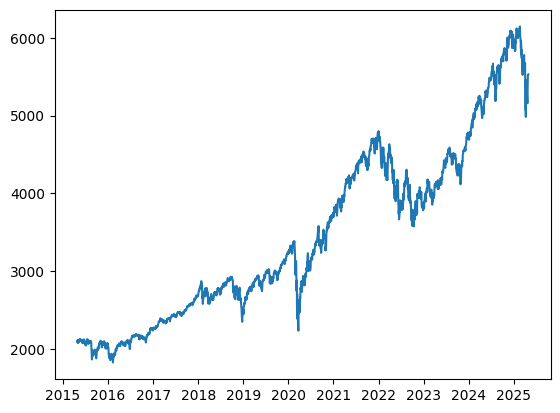

In [4]:
plt.plot(dates, prices)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)
prices

array([[0.06437211],
       [0.05942663],
       [0.06470581],
       ...,
       [0.84719138],
       [0.85656317],
       [0.85738356]])

In [6]:
def to_X_y(arr, window_size=5):
    X = []
    y = []
    for i in range(len(arr) - window_size):
        row = [a for a in arr[i : i + window_size]]
        X.append(row)
        label = arr[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
WINDOW_SIZE = 5
X, y = to_X_y(prices, WINDOW_SIZE)
X.shape, y.shape

((2510, 5, 1), (2510, 1))

In [8]:
X_train, y_train = X[:2_000], y[:2_000]
X_val, y_val = X[2_000:2_200], y[2_000:2_200]
X_test, y_test = X[2_200:], y[2_200:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2000, 5, 1), (2000, 1), (200, 5, 1), (200, 1), (310, 5, 1), (310, 1))

In [9]:
model = Sequential()
# model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(64))
# model.add(Dense(8, 'relu'))
# model.add(Dense(1, 'linear'))

model.add(LSTM(50, return_sequences=False, input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
cp = ModelCheckpoint('sp500model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam())

In [11]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
30/63 [=============>................] - ETA: 0s - loss: 0.0556 INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 4s 44ms/step - loss: 0.0304 - val_loss: 0.0047
Epoch 2/10
42/63 [===================>..........] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 39ms/step - loss: 9.4776e-04 - val_loss: 4.0284e-04
Epoch 3/10
57/63 [==========================>...] - ETA: 0s - loss: 3.2175e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 38ms/step - loss: 3.2006e-04 - val_loss: 3.5012e-04
Epoch 4/10
42/63 [===================>..........] - ETA: 0s - loss: 2.9326e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 3s 41ms/step - loss: 2.9124e-04 - val_loss: 2.7671e-04
Epoch 5/10
43/63 [===================>..........] - ETA: 0s - loss: 2.6827e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 39ms/step - loss: 2.6434e-04 - val_loss: 2.7026e-04
Epoch 6/10
43/63 [===================>..........] - ETA: 0s - loss: 2.3507e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 38ms/step - loss: 2.3710e-04 - val_loss: 2.4133e-04
Epoch 7/10
42/63 [===================>..........] - ETA: 0s - loss: 2.1831e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 3s 41ms/step - loss: 2.2227e-04 - val_loss: 1.9527e-04
Epoch 8/10
43/63 [===================>..........] - ETA: 0s - loss: 2.0891e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 38ms/step - loss: 2.0665e-04 - val_loss: 1.8121e-04
Epoch 9/10
43/63 [===================>..........] - ETA: 0s - loss: 2.0329e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 40ms/step - loss: 1.9307e-04 - val_loss: 1.6362e-04
Epoch 10/10
43/63 [===================>..........] - ETA: 0s - loss: 1.9081e-04INFO:tensorflow:Assets written to: sp500model/assets


INFO:tensorflow:Assets written to: sp500model/assets


63/63 [==============================] - 2s 38ms/step - loss: 1.8593e-04 - val_loss: 1.5851e-04


In [12]:
model = load_model('sp500model/')

In [13]:
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})
train_results

63/63 [==============================] - 0s 520us/step


,Train Predictions,Actuals
0,2114.697266,2080.149902
1,2111.247070,2088.000000
2,2112.104980,2116.100098
3,2109.421631,2105.330078
4,2106.426025,2099.120117
...,...,...
1995,4116.406738,4109.109863
1996,4115.084473,4108.939941
1997,4110.606934,4091.949951
1998,4110.714844,4146.220215


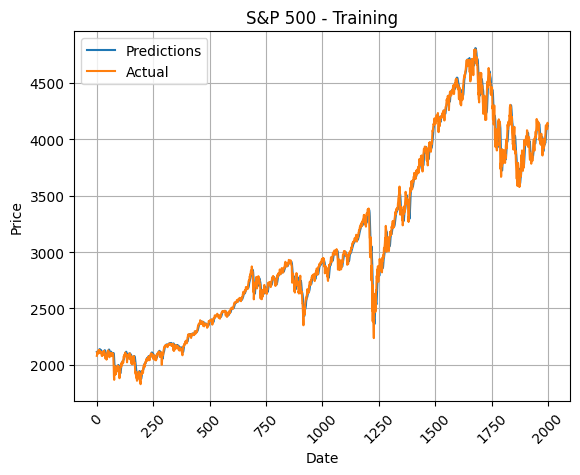

In [14]:
plt.plot(train_results['Train Predictions'], label='Predictions')
plt.plot(train_results['Actuals'], label='Actual')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500 - Training")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
val_predictions = model.predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions).flatten()
y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
val_results = pd.DataFrame(data={'Validation Predictions': val_predictions, 'Actuals': y_val})
val_results

7/7 [==============================] - 0s 709us/step


,Validation Predictions,Actuals
0,4124.310547,4151.319824
1,4132.338867,4154.870117
2,4142.487793,4154.520020
3,4157.705078,4129.790039
4,4156.974121,4133.520020
...,...,...
195,4858.210449,4894.160156
196,4882.213379,4890.970215
197,4893.541504,4927.930176
198,4907.403320,4924.970215


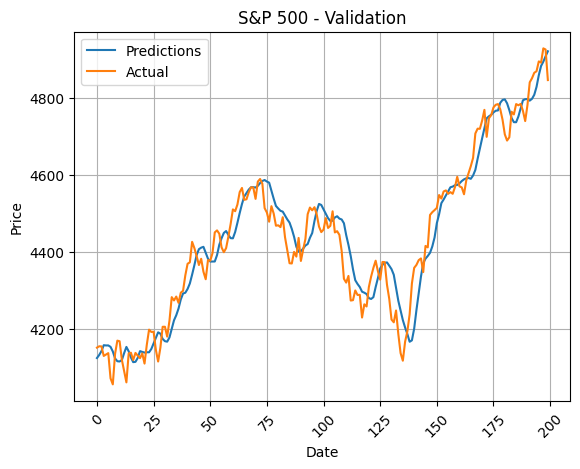

In [16]:
plt.plot(val_results['Validation Predictions'], label='Predictions')
plt.plot(val_results['Actuals'], label='Actual')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500 - Validation")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test})
test_results

10/10 [==============================] - 0s 612us/step


,Test Predictions,Actuals
0,4924.730957,4906.189941
1,4924.655273,4958.609863
2,4932.181152,4942.810059
3,4933.509277,4954.229980
4,4938.981445,4995.060059
...,...,...
305,5352.158691,5287.759766
306,5314.371094,5375.859863
307,5292.388184,5484.770020
308,5321.437012,5525.209961


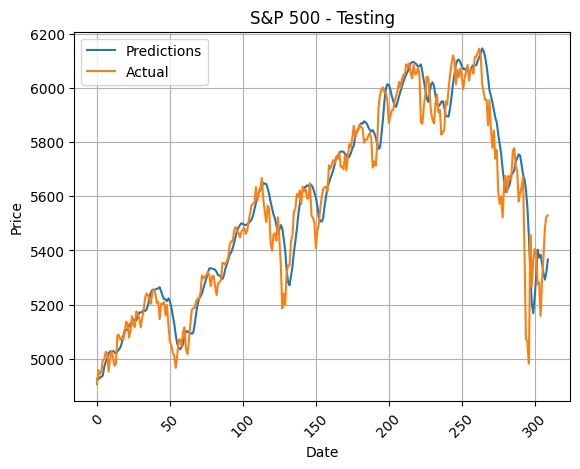

In [18]:
plt.plot(test_results['Test Predictions'], label='Predictions')
plt.plot(test_results['Actuals'], label='Actual')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500 - Testing")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def get_future_predictions(prices, future_days=60, window_size=5):
    future_predictions = []
    sliding_window = prices[-window_size:].flatten().tolist()

    for _ in range(future_days):
        window = np.array(sliding_window[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(window, verbose=False)
        future_predictions.append(prediction[0, 0])
        sliding_window.append(prediction[0, 0])

    return np.array(future_predictions)

In [20]:
FUTURE_DAYS = 30

future_predictions = get_future_predictions(prices, future_days=FUTURE_DAYS, window_size=WINDOW_SIZE).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions

array([[5451.521 ],
       [5499.9307],
       [5528.345 ],
       [5533.86  ],
       [5532.7095],
       [5532.826 ],
       [5552.385 ],
       [5562.5835],
       [5568.378 ],
       [5574.976 ],
       [5583.7583],
       [5594.408 ],
       [5602.529 ],
       [5610.3096],
       [5618.7207],
       [5627.553 ],
       [5636.317 ],
       [5644.594 ],
       [5652.9634],
       [5661.49  ],
       [5670.027 ],
       [5678.477 ],
       [5686.858 ],
       [5695.274 ],
       [5703.7007],
       [5712.098 ],
       [5720.4624],
       [5728.8086],
       [5737.15  ],
       [5745.473 ]], dtype=float32)

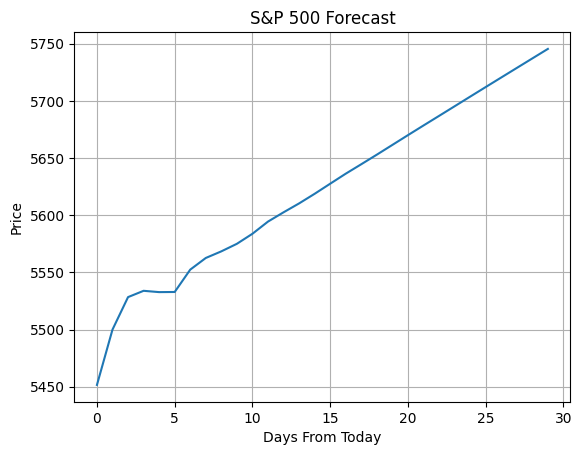

In [21]:
plt.plot(future_predictions, label='Future Predictions')
plt.title('S&P 500 Forecast')
plt.xlabel('Days From Today')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### NOTE
This is just a generalization of the average trend. The LSTM model is not taking into affect the randomness, which is why it is close to a linear line.